In [1]:
import numpy as np 
import pandas as pd
import neattext.functions as nfx
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
import pickle


In [4]:
data=pd.read_csv('../dataset/Suicide_Detection.csv')

In [5]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=np.random.randint(10))

In [6]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for str in tqdm(text):
        str=str.lower()
        str=nfx.remove_emails(str)
        str=nfx.remove_urls(str)
        str=nfx.remove_special_characters(str)
        str=nfx.remove_stopwords(str)
        text_length.append(len(str.split()))
        cleaned_text.append(str)
    return cleaned_text,text_length

In [7]:
cleaned_train_text, train_text_length = clean_text(train_data.text)
cleaned_test_text, test_text_length = clean_text(test_data.text)

100%|██████████| 46415/46415 [00:12<00:00, 3579.55it/s] 


In [8]:
cleaned_train_text

['indecision ive prolonging suicide day tell ill finally feelings worse thoughts getting darker recently met girl fyi im high school common knowledge depression hopefully bc sucks tells im quiet chill time true shes party girl im assuming im boring dont know want live try things work want die normally wouldnt want develop feelings anybody shes different heart skips beat thats positive emotion im basically dont want die knew things work wouldnt want stick things work biggest problem decide shes worth living idk talk depression shouldnt remain closed',
 'want die wanted die nowas title saysi f14 genuinely wish continue livingi live greece country known rich history notorious horribly broken neglected educational system neglect current minister education niki kerameus fucking things continously attempt fix iti actually death wishthe educational system pretty fuckedwith history centered greek history greeces glory days pages dedicated world historyand useless subjects ancient greek curricu

In [76]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

word_frequency = pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)
print(word_frequency)

                    word   count
63                    im  262061
91                  dont  170927
185                 like  144337
86                  want  119080
180                 know  104376
...                  ...     ...
129809           jfltcnu       1
129810          02025gel       1
129811  rjsi012125gelsjr       1
129812      u80ib08cnfvt       1
263772           bullet2       1

[263773 rows x 2 columns]


In [77]:
tokenizer.word_index

{'im': 1,
 'dont': 2,
 'like': 3,
 'want': 4,
 'know': 5,
 'feel': 6,
 'life': 7,
 'ive': 8,
 'cant': 9,
 'people': 10,
 'time': 11,
 'think': 12,
 'going': 13,
 'friends': 14,
 'help': 15,
 'day': 16,
 'years': 17,
 'filler': 18,
 'things': 19,
 'got': 20,
 'good': 21,
 'fucking': 22,
 'school': 23,
 'way': 24,
 'anymore': 25,
 'need': 26,
 'didnt': 27,
 'family': 28,
 'better': 29,
 'fuck': 30,
 'die': 31,
 'end': 32,
 'talk': 33,
 'love': 34,
 'live': 35,
 'kill': 36,
 'year': 37,
 'ill': 38,
 'right': 39,
 'suicide': 40,
 'hate': 41,
 'work': 42,
 'shit': 43,
 'thing': 44,
 'bad': 45,
 'parents': 46,
 'person': 47,
 'told': 48,
 'friend': 49,
 'thats': 50,
 'care': 51,
 'thought': 52,
 'tell': 53,
 'mom': 54,
 'said': 55,
 'point': 56,
 'doesnt': 57,
 'getting': 58,
 'tried': 59,
 'try': 60,
 'happy': 61,
 'job': 62,
 'long': 63,
 'feeling': 64,
 'away': 65,
 'find': 66,
 'trying': 67,
 'lot': 68,
 'wanted': 69,
 'pain': 70,
 'started': 71,
 'tired': 72,
 'best': 73,
 'hard': 74,
 

# Process Text For the Model

In [78]:
train_text_seq= tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad= pad_sequences(train_text_seq,maxlen=100)

test_text_seq= tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad= pad_sequences(test_text_seq,maxlen=100)

In [79]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

# Embedding Model 

In [80]:
with open('./dataset/glove.840B.300d.pkl', 'rb') as fp:
    glove = pickle.load(fp)

In [81]:
dataset_length=len(tokenizer.word_index) + 1

embedding_matrix=np.zeros((dataset_length,300), dtype=float) #pad 0 to prep the matrix to match with the shape of our dataset
for word,i in tokenizer.word_index.items():
    num = glove.get(word)
    if num is not None:
        embedding_matrix[i] = num

# Model Building

In [82]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(100,)))
model.add(tf.keras.layers.Embedding(dataset_length,300,weights=[embedding_matrix],trainable=False))
model.add(tf.keras.layers.LSTM(20,return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(256,activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          79132200  
                                                                 
 lstm_3 (LSTM)               (None, 100, 20)           25680     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               5376      
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 79,163,513
Trainable params: 31,313
Non-trainable params: 79,132,200
_____________________________________

In [83]:
early_break = EarlyStopping(monitor='loss', patience=5)
reduce_learning_rate = ReduceLROnPlateau(patience=3)

result=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_break,reduce_learning_rate])

Epoch 1/20
726/726 [==============================] - 104s 141ms/step - loss: 0.3499 - accuracy: 0.8462 - val_loss: 0.2581 - val_accuracy: 0.8970 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 94s 129ms/step - loss: 0.2366 - accuracy: 0.9060 - val_loss: 0.2591 - val_accuracy: 0.8945 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 95s 131ms/step - loss: 0.2152 - accuracy: 0.9152 - val_loss: 0.2101 - val_accuracy: 0.9183 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 95s 131ms/step - loss: 0.2025 - accuracy: 0.9210 - val_loss: 0.2037 - val_accuracy: 0.9211 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 97s 134ms/step - loss: 0.1871 - accuracy: 0.9280 - val_loss: 0.1970 - val_accuracy: 0.9231 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 2116s 3s/step - loss: 0.1692 - accuracy: 0.9351 - val_loss: 0.1897 - val_accuracy: 0.9262 - lr: 0.1000
Epoch 7/20
726/726 [==============================] 

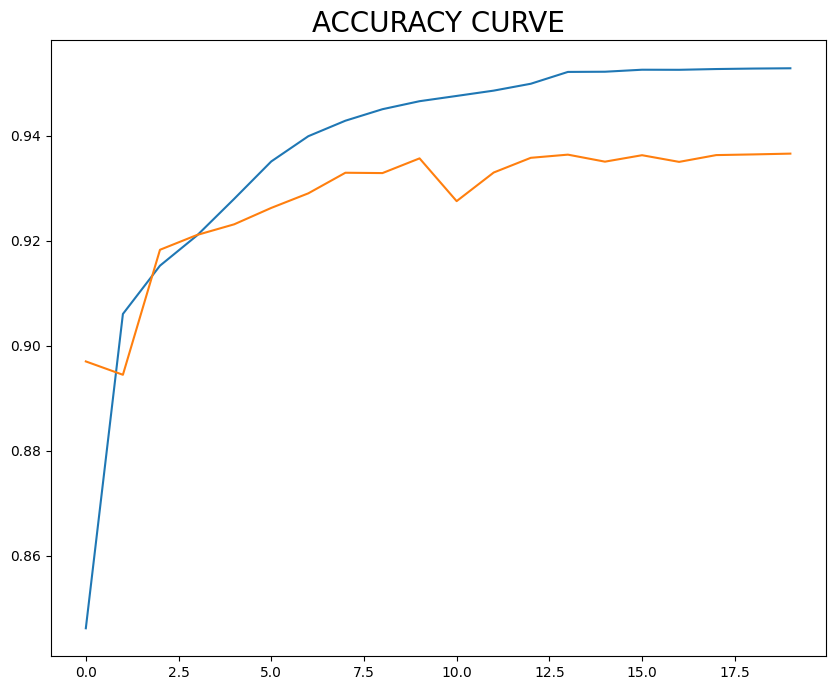

In [87]:
plt.figure(figsize=(10,8))
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

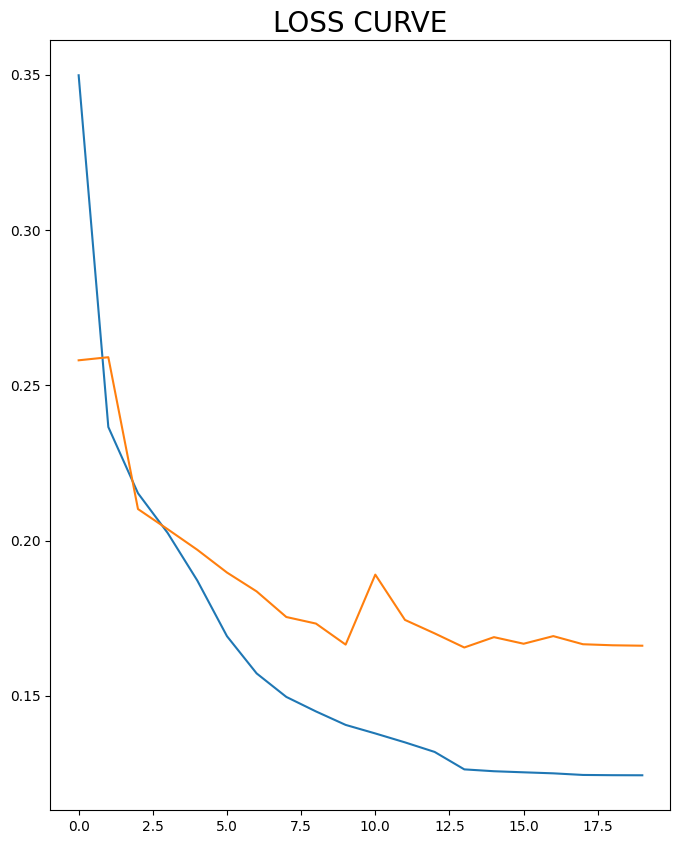

In [88]:
plt.figure(figsize=(8,10))
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [89]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets
